#Install

In [21]:
!pip install imageio matplotlib numpy


#Imports & Global Settings

In [22]:
import random
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from collections import deque
from queue import PriorityQueue
from IPython.display import Image, display
import copy

#Pac-Man Environment

In [23]:
# -------------------------
# PACMAN ENVIRONMENT
# -------------------------
class PacmanEnv:
    def __init__(self, width=10, height=10, num_ghosts=1, num_pellets=5):
        self.width = width
        self.height = height
        self.num_ghosts = num_ghosts
        self.num_pellets = num_pellets
        self.reset()
        self.frames = []

    def reset(self):
        self.pacman_pos = (0, 0)
        self.ghosts = [(self.width-1, self.height-1)]
        self.pellets = random.sample(
            [(x, y) for x in range(self.width) for y in range(self.height)
             if (x, y) not in self.ghosts and (x, y) != self.pacman_pos],
            self.num_pellets
        )
        self.steps = 0
        return self.pacman_pos

    def copy(self):
        new = PacmanEnv(self.width, self.height, self.num_ghosts, self.num_pellets)
        new.pacman_pos = self.pacman_pos
        new.ghosts = list(self.ghosts)
        new.pellets = list(self.pellets)
        new.steps = self.steps
        return new

    def is_terminal(self):
        return self.pacman_pos in self.ghosts or len(self.pellets) == 0

    def legal_moves(self, pos=None):
        if pos is None:
            pos = self.pacman_pos
        moves = []
        for dx, dy, a in [(-1,0,'LEFT'),(1,0,'RIGHT'),(0,-1,'UP'),(0,1,'DOWN')]:
            nx, ny = pos[0]+dx, pos[1]+dy
            if 0 <= nx < self.width and 0 <= ny < self.height:
                moves.append(a)
        return moves

    def move(self, pos, action):
        x, y = pos
        if action == 'LEFT':  return (x-1, y)
        if action == 'RIGHT': return (x+1, y)
        if action == 'UP':    return (x, y-1)
        if action == 'DOWN':  return (x, y+1)
        return pos

    def step(self, action):
        self.steps += 1
        self.pacman_pos = self.move(self.pacman_pos, action)

        if self.pacman_pos in self.pellets:
            self.pellets.remove(self.pacman_pos)

        # Ghosts move randomly
        self.ghosts = [
            self.move(g, random.choice(self.legal_moves(g)))
            for g in self.ghosts
        ]

        done = self.is_terminal()
        reward = -1
        if self.pacman_pos in self.ghosts:
            reward = -100
        elif len(self.pellets) == 0:
            reward = 100

        return self.pacman_pos, reward, done

    def render(self, capture_frame=False, title=""):
        grid = np.zeros((self.height, self.width, 3))
        for x, y in self.pellets:
            grid[y][x] = [1,1,0]  # yellow pellet
        for x, y in self.ghosts:
            grid[y][x] = [1,0,0]  # red ghost
        px, py = self.pacman_pos
        grid[py][px] = [0,0,1]  # blue pacman

        plt.imshow(grid)
        plt.axis('off')
        if title:
            plt.title(title)
        if capture_frame:
            plt.savefig("frame.png")
            self.frames.append(imageio.imread("frame.png"))
        plt.close()


    def clear_frames(self):
        self.frames = []

    def get_frames(self):
        return self.frames

#Evaluation

In [24]:
# -------------------------
# EVALUATION FUNCTION
# -------------------------
def eval_fn(env):
    if env.pacman_pos in env.ghosts:
        return -1000
    if len(env.pellets) == 0:
        return 1000
    pac = env.pacman_pos
    pellet_dist = min(abs(pac[0]-p[0])+abs(pac[1]-p[1]) for p in env.pellets)
    ghost_dist = min(abs(pac[0]-g[0])+abs(pac[1]-g[1]) for g in env.ghosts)
    return -pellet_dist + 2 * ghost_dist

#RandomPlayer

In [25]:
# -------------------------
# Random Agent
# -------------------------
class RandomPlayer:
    def get_action(self, env):
        return random.choice(env.legal_moves())

#Search Agents (BFS, DFS, UCS, Greedy, A*)

BFS

In [26]:
# -------------------------
# BFS Agent
# -------------------------
class BFSPlayer:
    def get_action(self, env):
        start = env.pacman_pos
        targets = env.pellets
        if not targets: return random.choice(env.legal_moves())
        q = deque([(start, [])])
        visited = set([start])
        while q:
            pos, path = q.popleft()
            if pos in targets: return path[0] if path else random.choice(env.legal_moves())
            for a in env.legal_moves(pos):
                new_pos = env.move(pos,a)
                if new_pos not in visited:
                    visited.add(new_pos)
                    q.append((new_pos, path+[a]))
        return random.choice(env.legal_moves())

DFS

In [27]:
# -------------------------
# DFS Agent
# -------------------------
class DFSPlayer(BFSPlayer):
    def get_action(self, env):
        start = env.pacman_pos
        targets = env.pellets
        if not targets: return random.choice(env.legal_moves())
        stack = [(start, [])]
        visited = set([start])
        while stack:
            pos, path = stack.pop()
            if pos in targets: return path[0] if path else random.choice(env.legal_moves())
            for a in env.legal_moves(pos):
                new_pos = env.move(pos,a)
                if new_pos not in visited:
                    visited.add(new_pos)
                    stack.append((new_pos, path+[a]))
        return random.choice(env.legal_moves())

UCS

In [28]:
# -------------------------
# UCS Agent
# -------------------------
class UCSPlayer:
    def get_action(self, env):
        start = env.pacman_pos
        targets = env.pellets
        if not targets: return random.choice(env.legal_moves())
        pq = PriorityQueue()
        pq.put((0, start, []))
        visited = {start: 0}
        while not pq.empty():
            cost, pos, path = pq.get()
            if pos in targets: return path[0] if path else random.choice(env.legal_moves())
            for a in env.legal_moves(pos):
                new_pos = env.move(pos,a)
                new_cost = cost+1
                if new_pos not in visited or new_cost<visited[new_pos]:
                    visited[new_pos]=new_cost
                    pq.put((new_cost, new_pos, path+[a]))
        return random.choice(env.legal_moves())

Greedy Best-First Search

In [29]:
# -------------------------
# Greedy Agent
# -------------------------
class GreedyPlayer:
    def heuristic(self,pos,targets):
        return min(abs(pos[0]-t[0])+abs(pos[1]-t[1]) for t in targets)
    def get_action(self, env):
        start = env.pacman_pos
        targets = env.pellets
        if not targets: return random.choice(env.legal_moves())
        pq = PriorityQueue()
        pq.put((self.heuristic(start,targets), start, []))
        visited = set([start])
        while not pq.empty():
            h,pos,path = pq.get()
            if pos in targets: return path[0] if path else random.choice(env.legal_moves())
            for a in env.legal_moves(pos):
                new_pos = env.move(pos,a)
                if new_pos not in visited:
                    visited.add(new_pos)
                    pq.put((self.heuristic(new_pos,targets), new_pos, path+[a]))
        return random.choice(env.legal_moves())

A*

In [30]:
# -------------------------
# A* Agent
# -------------------------
class AStarPlayer:
    def heuristic(self,pos,targets,ghosts):
        if not targets: return 0
        min_dist = min(abs(pos[0]-t[0])+abs(pos[1]-t[1]) for t in targets)
        ghost_penalty = 0
        if ghosts:
            min_ghost = min(abs(pos[0]-g[0])+abs(pos[1]-g[1]) for g in ghosts)
            if min_ghost<=1: ghost_penalty=100
        return min_dist+ghost_penalty

    def get_action(self, env):
        start = env.pacman_pos
        targets = env.pellets
        ghosts = env.ghosts
        if not targets: return random.choice(env.legal_moves())
        pq = PriorityQueue()
        pq.put((0+self.heuristic(start,targets,ghosts),0,start,[]))
        visited = {start:0}
        while not pq.empty():
            f,g,pos,path = pq.get()
            if pos in targets: return path[0] if path else random.choice(env.legal_moves())
            for a in env.legal_moves(pos):
                new_pos = env.move(pos,a)
                new_g = g+1
                if new_pos not in visited or new_g<visited[new_pos]:
                    visited[new_pos]=new_g
                    pq.put((new_g+self.heuristic(new_pos,targets,ghosts), new_g, new_pos, path+[a]))
        return random.choice(env.legal_moves())

#Minimax & Alpha-Beta Players

Minimax Player

In [31]:
# -------------------------
# Minimax
# -------------------------
class MinimaxPlayer:
    def __init__(self, depth=2):
        self.depth = depth
    def get_action(self, env):
        best, best_action = -1e9, random.choice(env.legal_moves())
        for a in env.legal_moves():
            e = env.copy()
            e.pacman_pos = e.move(e.pacman_pos, a)
            val = self.min_value(e, self.depth)
            if val > best:
                best = val
                best_action = a
        return best_action
    def max_value(self, env, d):
        if d==0 or env.is_terminal(): return eval_fn(env)
        return max([self.min_value(env.copy(), d-1)])
    def min_value(self, env, d):
        if d==0 or env.is_terminal(): return eval_fn(env)
        v=1e9
        for i,g in enumerate(env.ghosts):
            for a in env.legal_moves(g):
                e=env.copy()
                e.ghosts[i]=e.move(g,a)
                v=min(v,self.max_value(e,d-1))
        return v

Alpha-Beta Player

In [32]:
# -------------------------
# Alpha-Beta
# -------------------------
class AlphaBetaPlayer(MinimaxPlayer):
    def max_value(self, env, d, a=-1e9, b=1e9):
        if d==0 or env.is_terminal(): return eval_fn(env)
        v=-1e9
        for act in env.legal_moves():
            e=env.copy()
            e.pacman_pos=e.move(e.pacman_pos,act)
            v=max(v,self.min_value(e,d-1,a,b))
            if v>=b: return v
            a=max(a,v)
        return v
    def min_value(self, env, d, a=-1e9, b=1e9):
        if d==0 or env.is_terminal(): return eval_fn(env)
        v=1e9
        for i,g in enumerate(env.ghosts):
            for act in env.legal_moves(g):
                e=env.copy()
                e.ghosts[i]=e.move(g,act)
                v=min(v,self.max_value(e,d-1,a,b))
                if v<=a: return v
                b=min(b,v)
        return v

#AdvancedPlayer (Q-Learning)

In [33]:
# -------------------------
# Q-Learning (RL)
# -------------------------
class RLPlayer:
    def __init__(self):
        self.Q={}
        self.alpha=0.5
        self.gamma=0.9
        self.eps=0.2
    def get_action(self, env):
        if random.random()<self.eps: return random.choice(env.legal_moves())
        return max(env.legal_moves(), key=lambda a:self.Q.get((env.pacman_pos,a),0))
    def learn(self, env, episodes=50):
        for _ in range(episodes):
            s=env.reset()
            done=False
            while not done:
                a=self.get_action(env)
                ns,r,done=env.step(a)
                self.Q[(s,a)]=self.Q.get((s,a),0)+self.alpha*(r-self.Q.get((s,a),0))
                s=ns

#GIFs

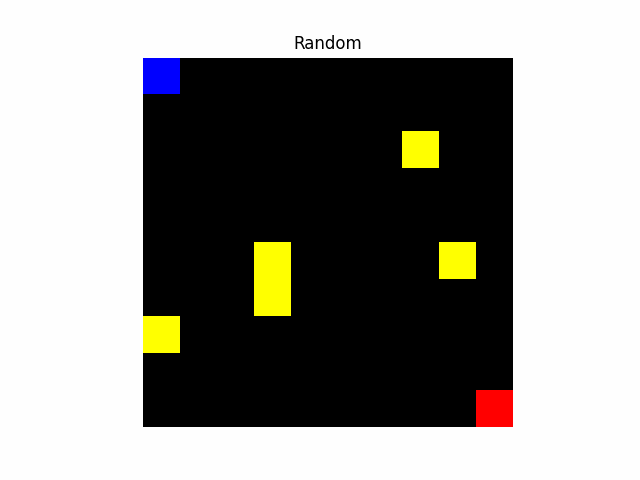

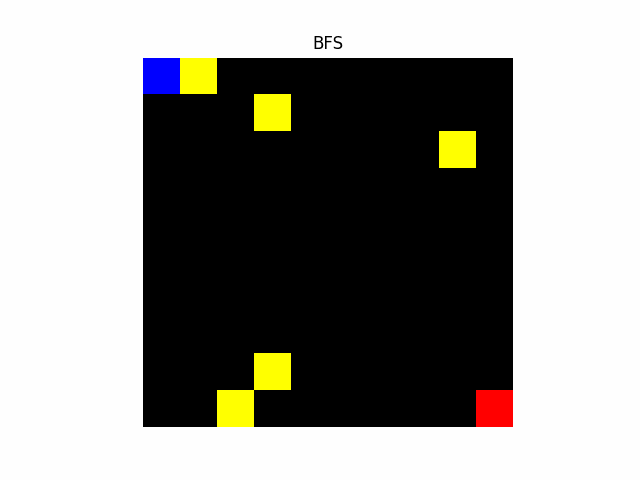

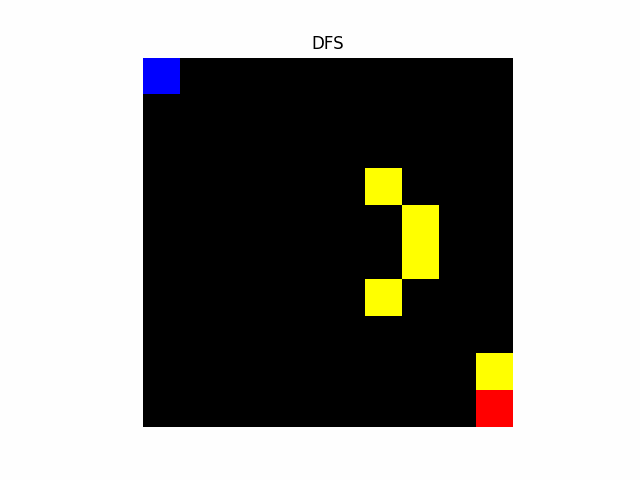

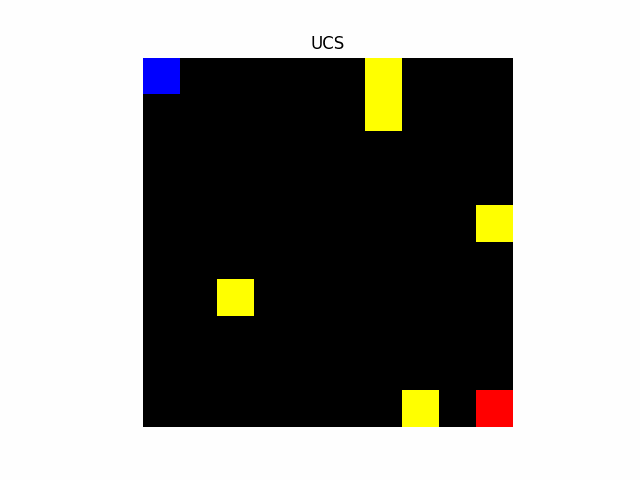

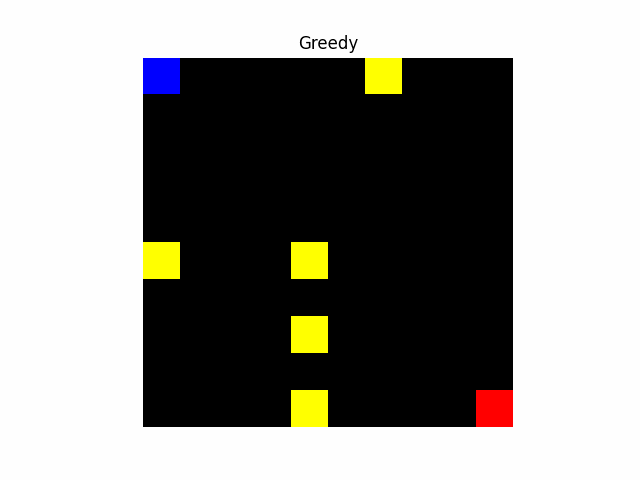

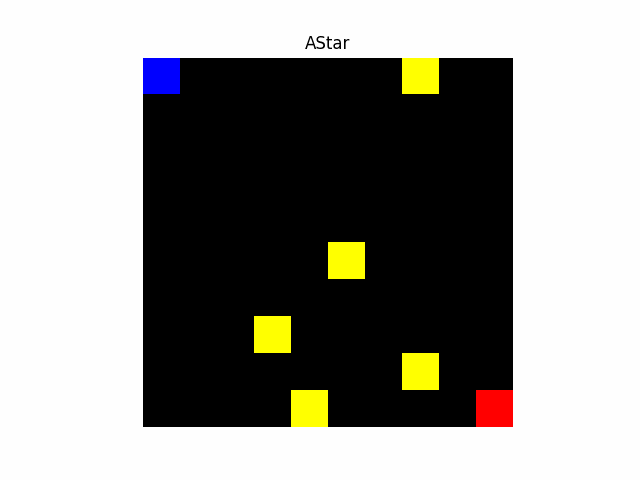

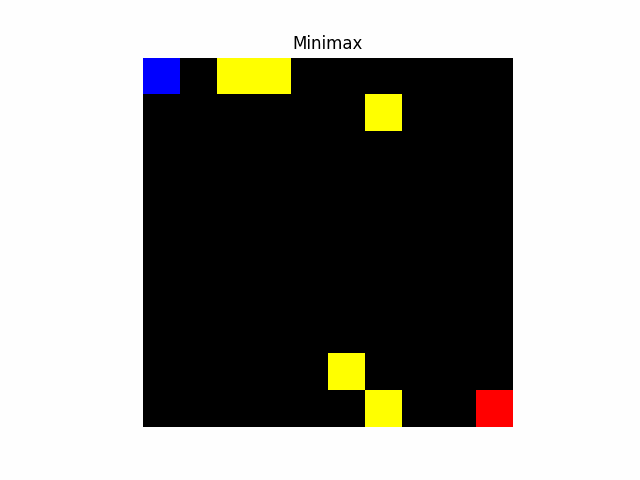

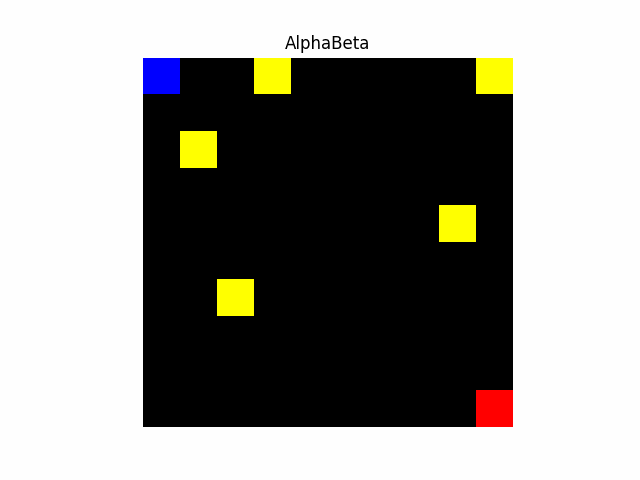

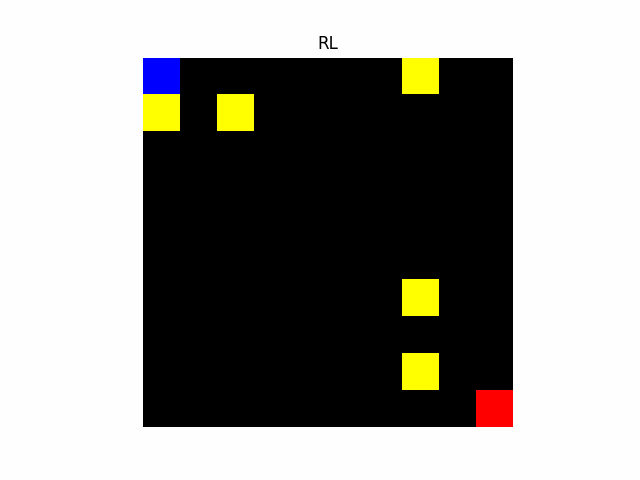

In [35]:
def create_gif(frames, name):
    imageio.mimsave(name, frames, fps=8)

agents = [
    RandomPlayer(),
    BFSPlayer(),
    DFSPlayer(),
    UCSPlayer(),
    GreedyPlayer(),
    AStarPlayer(),
    MinimaxPlayer(),
    AlphaBetaPlayer(),
    RLPlayer()
]

names = ["Random","BFS","DFS","UCS","Greedy","AStar","Minimax","AlphaBeta","RL"]
env = PacmanEnv(width=10,height=10,num_ghosts=1,num_pellets=5)

for p, name in zip(agents, names):
    if isinstance(p, RLPlayer):
        p.learn(env, episodes=10)
        env.reset() # Reset env after learning for the demonstration run
    else:
        env.reset()

    env.clear_frames()
    done = False
    while not done and env.steps < 150:
        env.render(capture_frame=True, title=name)  # Changed to env.render()
        a = p.get_action(env)
        _, _, done = env.step(a)
    create_gif(env.get_frames(), f"{name}.gif")
    display(Image(filename=f"{name}.gif"))

#Performance Evaluation

In [36]:
class PerformanceTracker:
    def __init__(self):
        self.results={}
    def log(self,agent_name,win,score,steps):
        if agent_name not in self.results:
            self.results[agent_name]={"wins":0,"games":0,"total_score":0,"total_steps":0}
        self.results[agent_name]["games"]+=1
        self.results[agent_name]["total_score"]+=score
        self.results[agent_name]["total_steps"]+=steps
        if win: self.results[agent_name]["wins"]+=1
    def summary(self):
        print("\n=== FINAL SCOREBOARD ===")
        print(f"{'Agent':15s} | {'Win %':6s} | {'Avg Score':10s} | {'Avg Steps':10s}")
        print("-"*55)
        for agent,r in self.results.items():
            win_rate=100*r["wins"]/r["games"]
            avg_score=r["total_score"]/r["games"]
            avg_steps=r["total_steps"]/r["games"]
            print(f"{agent:15s} | {win_rate:6.1f} | {avg_score:10.2f} | {avg_steps:10.1f}")

def run_agent(agent, env, episodes=5):
    tracker=[]
    for _ in range(episodes):
        state=env.reset()
        score=0
        done=False
        steps=0
        while not done and steps<200:
            action=agent.get_action(env)
            state,reward,done=env.step(action)
            score+=reward
            steps+=1
        win=(len(env.pellets)==0 and score>-100)
        tracker.append((win,score,steps))
    return tracker

env = PacmanEnv(width=10,height=10,num_ghosts=1,num_pellets=5)
tracker=PerformanceTracker()

agents_dict={
    "Random":RandomPlayer(),
    "BFS":BFSPlayer(),
    "DFS":DFSPlayer(),
    "UCS":UCSPlayer(),
    "Greedy":GreedyPlayer(),
    "A*":AStarPlayer(),
    "Minimax":MinimaxPlayer(),
    "AlphaBeta":AlphaBetaPlayer(),
    "RL":RLPlayer()
}

for name,agent in agents_dict.items():
    print(f"Evaluating {name}...")
    if name=="RL": agent.learn(env,episodes=20)
    results=run_agent(agent,env,episodes=5)
    for win,score,steps in results:
        tracker.log(name,win,score,steps)

tracker.summary()

Evaluating Random...
Evaluating BFS...
Evaluating DFS...
Evaluating UCS...
Evaluating Greedy...
Evaluating A*...
Evaluating Minimax...
Evaluating AlphaBeta...
Evaluating RL...

=== FINAL SCOREBOARD ===
Agent           | Win %  | Avg Score  | Avg Steps 
-------------------------------------------------------
Random          |    0.0 |    -181.20 |      102.0
BFS             |  100.0 |      82.40 |       18.6
DFS             |    0.0 |    -193.00 |      153.4
UCS             |  100.0 |      81.00 |       20.0
Greedy          |  100.0 |      80.40 |       20.6
A*              |  100.0 |      77.60 |       23.4
Minimax         |    0.0 |    -200.00 |      200.0
AlphaBeta       |    0.0 |    -200.00 |      200.0
RL              |    0.0 |    -189.80 |      150.2


#Plots

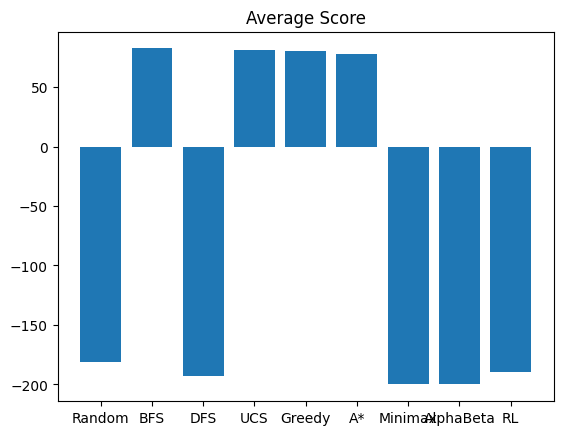

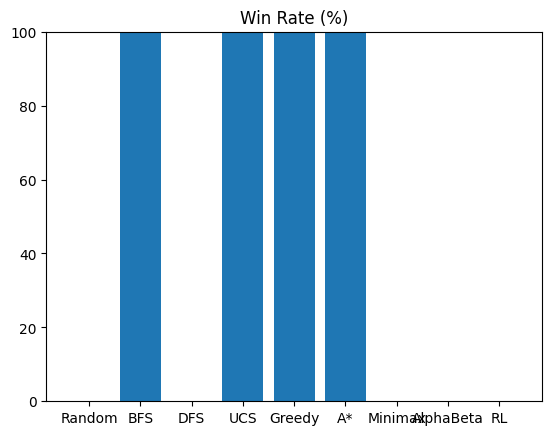

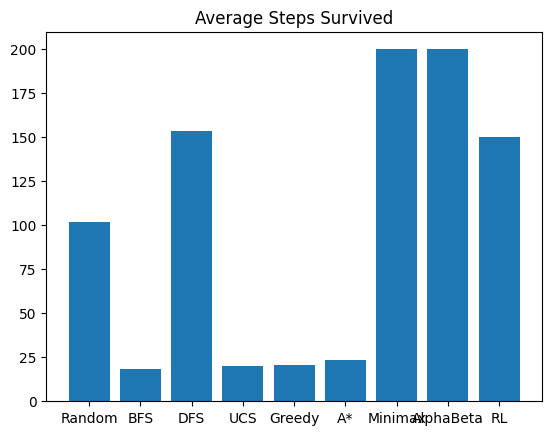

In [37]:
# PLOTS
def plot_agent_comparison(tracker):
    agents=list(tracker.results.keys())
    avg_scores=[]
    win_rates=[]
    avg_steps=[]
    for a in agents:
        r=tracker.results[a]
        avg_scores.append(r["total_score"]/r["games"])
        win_rates.append(100*r["wins"]/r["games"])
        avg_steps.append(r["total_steps"]/r["games"])
    plt.figure()
    plt.bar(agents,avg_scores);plt.title("Average Score");plt.show()
    plt.figure()
    plt.bar(agents,win_rates);plt.title("Win Rate (%)");plt.ylim(0,100);plt.show()
    plt.figure()
    plt.bar(agents,avg_steps);plt.title("Average Steps Survived");plt.show()

plot_agent_comparison(tracker)